In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [20]:
trades = pd.read_csv("historical_data (1).csv")
sentiment = pd.read_csv("fear_greed_index (1).csv")

print("Trades Shape:", trades.shape)
print("Sentiment Shape:", sentiment.shape)

print("\nMissing Values (Trades):\n", trades.isnull().sum())
print("\nMissing Values (Sentiment):\n", sentiment.isnull().sum())

print("\nDuplicate Trades:", trades.duplicated().sum())
print("Duplicate Sentiment:", sentiment.duplicated().sum())

Trades Shape: (211224, 16)
Sentiment Shape: (2644, 4)

Missing Values (Trades):
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Missing Values (Sentiment):
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate Trades: 0
Duplicate Sentiment: 0


In [22]:
trades.columns = trades.columns.str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.lower().str.replace(" ", "_")

In [24]:
trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    format="%d-%m-%Y %H:%M",
    errors='coerce'
)

trades['date'] = trades['timestamp_ist'].dt.date

In [26]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'])
trades['date'] = trades['timestamp_ist'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [27]:
daily_trader = trades.groupby(['account', 'date']).agg(
    daily_pnl=('closed_pnl', 'sum'),
    total_trades=('trade_id', 'count'),
    avg_trade_size=('size_usd', 'mean'),
    total_volume=('size_usd', 'sum'),
    total_fees=('fee', 'sum')
).reset_index()

In [28]:
trades['win'] = trades['closed_pnl'] > 0

win_rate = trades.groupby(['account','date'])['win'].mean().reset_index()
win_rate.rename(columns={'win':'win_rate'}, inplace=True)

daily_trader = daily_trader.merge(win_rate, on=['account','date'], how='left')

In [29]:
long_short = trades.groupby(['account','date','side'])['trade_id'].count().unstack().fillna(0)

long_short['long_short_ratio'] = long_short.get('BUY',0) / (long_short.get('SELL',1))

long_short = long_short.reset_index()[['account','date','long_short_ratio']]

daily_trader = daily_trader.merge(long_short, on=['account','date'], how='left')

In [30]:
data = daily_trader.merge(
    sentiment[['date','classification','value']],
    on='date',
    how='left'
)

print("Final Dataset Shape:", data.shape)

Final Dataset Shape: (2341, 11)


In [31]:
performance = data.groupby('classification').agg(
    avg_daily_pnl=('daily_pnl','mean'),
    median_daily_pnl=('daily_pnl','median'),
    avg_win_rate=('win_rate','mean'),
    avg_trades=('total_trades','mean'),
    avg_volume=('total_volume','mean')
).reset_index()

print(performance)

  classification  avg_daily_pnl  median_daily_pnl  avg_win_rate  avg_trades  \
0   Extreme Fear    4619.439053        218.377399      0.329659  133.750000   
1  Extreme Greed    5161.922644        418.319862      0.386387   76.030418   
2           Fear    5328.818161        107.892532      0.364033   98.153968   
3          Greed    3318.100730        158.214922      0.343559   77.628086   
4        Neutral    3438.618818        167.551743      0.355414  100.228723   

      avg_volume  
0  715526.634000  
1  236625.788156  
2  767182.206016  
3  445343.356049  
4  479367.189043  


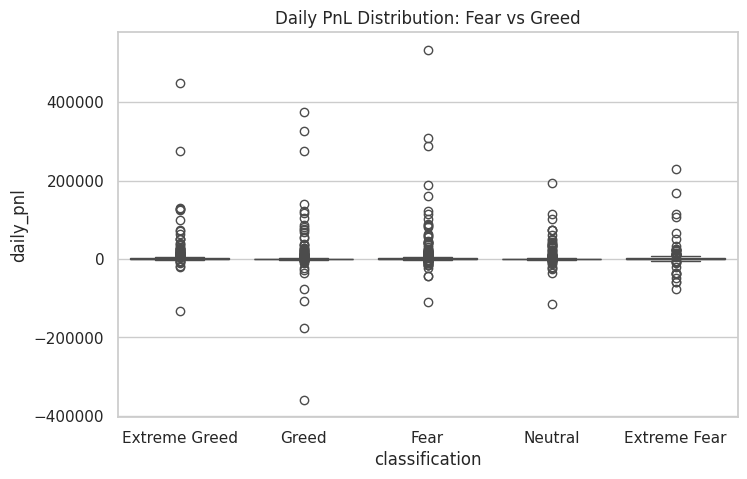

In [32]:
#Vizualization
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='daily_pnl', data=data)
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()

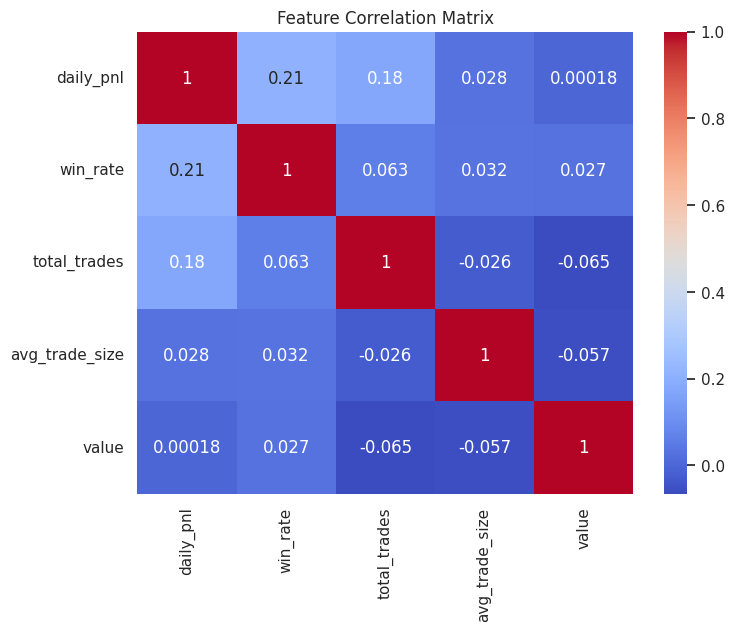

In [40]:
plt.figure(figsize=(8,6))
corr = data[['daily_pnl','win_rate','total_trades','avg_trade_size','value']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [33]:
behavior = data.groupby('classification').agg(
    avg_trades=('total_trades','mean'),
    avg_trade_size=('avg_trade_size','mean'),
    avg_long_short_ratio=('long_short_ratio','mean')
).reset_index()

print(behavior)

  classification  avg_trades  avg_trade_size  avg_long_short_ratio
0   Extreme Fear  133.750000     6773.464125                   inf
1  Extreme Greed   76.030418     5371.637182                   inf
2           Fear   98.153968     8975.928546                   inf
3          Greed   77.628086     6427.866594                   inf
4        Neutral  100.228723     6963.694861                   inf


In [34]:
volume_threshold = data['total_volume'].median()

data['volume_segment'] = np.where(
    data['total_volume'] > volume_threshold,
    'High Volume',
    'Low Volume'
)

In [35]:
freq_threshold = data['total_trades'].median()

data['frequency_segment'] = np.where(
    data['total_trades'] > freq_threshold,
    'Frequent',
    'Infrequent'
)

In [36]:
consistency = data.groupby('account')['daily_pnl'].std().reset_index()
consistency.columns = ['account','pnl_std']

data = data.merge(consistency, on='account')

std_threshold = data['pnl_std'].median()

data['consistency_segment'] = np.where(
    data['pnl_std'] < std_threshold,
    'Consistent',
    'Inconsistent'
)

In [37]:
segment_analysis = data.groupby(['classification','volume_segment']).agg(
    avg_pnl=('daily_pnl','mean'),
    avg_win_rate=('win_rate','mean')
).reset_index()

print(segment_analysis)

  classification volume_segment      avg_pnl  avg_win_rate
0   Extreme Fear    High Volume  7667.702713      0.356677
1   Extreme Fear     Low Volume   388.267107      0.292157
2  Extreme Greed    High Volume  9099.205644      0.428597
3  Extreme Greed     Low Volume  1513.085284      0.347270
4           Fear    High Volume  9792.670383      0.364935
5           Fear     Low Volume   864.965939      0.363130
6          Greed    High Volume  6090.547483      0.408375
7          Greed     Low Volume   695.515964      0.282246
8        Neutral    High Volume  6525.021946      0.406984
9        Neutral     Low Volume   183.559781      0.301027


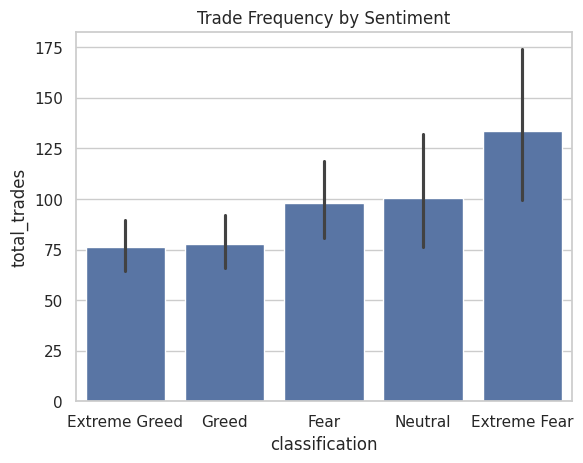

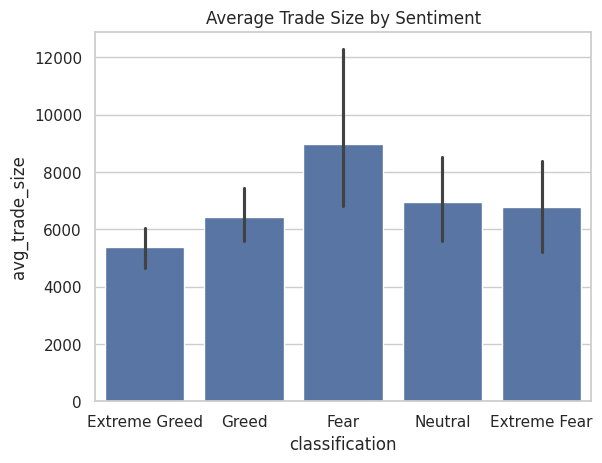

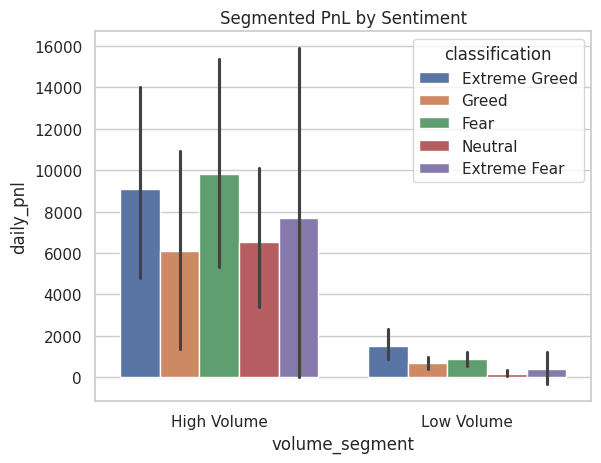

In [38]:
sns.barplot(x='classification', y='total_trades', data=data)
plt.title("Trade Frequency by Sentiment")
plt.show()

sns.barplot(x='classification', y='avg_trade_size', data=data)
plt.title("Average Trade Size by Sentiment")
plt.show()

sns.barplot(x='volume_segment', y='daily_pnl', hue='classification', data=data)
plt.title("Segmented PnL by Sentiment")
plt.show()